## _*Using Qiskit Aqua's quantum evolution functionality*_

This notebook demonstrates how to realize quantum evolution using the `Qiskit Aqua` library.

Further information is available for the algorithms in the github repo aqua/readme.md

First, an WeightedPauliOperator instance is created for our randomly generated Hamiltonian. We also randomly generate an initial quantum state `state_in`.

In [1]:
import numpy as np
from scipy.linalg import expm
from qiskit import BasicAer
from qiskit import execute as q_execute
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.operators import MatrixOperator, op_converter
from qiskit.aqua.components.initial_states import Custom

num_qubits = 2
evo_time = 1
temp = np.random.random((2 ** num_qubits, 2 ** num_qubits))
h1 = temp + temp.T
qubitOp = MatrixOperator(matrix=h1)
state_in = Custom(num_qubits, state='random')

With the operator and the initial state, we can easily compute the groundtruth evolution result as follows.

In [2]:
state_in_vec = state_in.construct_circuit('vector')
groundtruth = expm(-1.j * h1 * evo_time) @ state_in_vec
print('The directly computed groundtruth evolution result state is\n{}.'.format(groundtruth))

The directly computed groundtruth evolution result state is
[-0.52115696+0.33380779j -0.03365282+0.24949932j -0.53816051+0.37654038j
 -0.33346721-0.10481218j].


The `evolve` method as provided by the `MatrixOperator` class also provides the ability to compute the evolution groundtruth via the same matrix and vector multiplication. Therefore, we can also compute the evolution's groundtruth result state as follows, which we can easily verify to be the same as the `groundtruth` we just computed.

In [3]:
groundtruth_evolution = qubitOp.evolve(state_in_vec, evo_time, num_time_slices=0)
print('The groundtruth evolution result as computed by the Dynamics algorithm is\n{}.'.format(groundtruth_evolution))
np.testing.assert_allclose(groundtruth_evolution, groundtruth)

The groundtruth evolution result as computed by the Dynamics algorithm is
[-0.52115696+0.33380779j -0.03365282+0.24949932j -0.53816051+0.37654038j
 -0.33346721-0.10481218j].


Next, let's actually build the quantum circuit, which involves the circuit for putting the system in the specified initial state, and the actual `evolution` circuit corresponding to the operator we generated, for which, let's, for example, use the `3`rd order `suzuki` expansion.

Furthermore, we need to convert `MatrixOperator` to `WeightedPauliOperator` to generate circuits for quantum device.

In [4]:
qubit_op = op_converter.to_weighted_pauli_operator(qubitOp)

quantum_registers = QuantumRegister(qubit_op.num_qubits)
circuit = state_in.construct_circuit('circuit', quantum_registers)
circuit += qubit_op.evolve(
    None, evo_time, num_time_slices=1,
    quantum_registers=quantum_registers,
    expansion_mode='suzuki',
    expansion_order=3
)

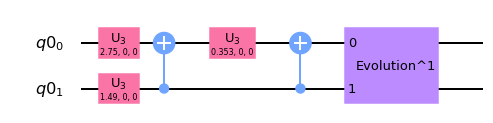

In [5]:
circuit.draw(output='mpl')

With the circuit built, we can now execute the circuit to get the evolution result. We use the `statevector_simulator` backend for the purpose of this demonstration.

In [6]:
backend = BasicAer.get_backend('statevector_simulator')
job = q_execute(circuit, backend)
circuit_execution_result = np.asarray(job.result().get_statevector(circuit))
print('The evolution result state from executing the Dynamics circuit is\n{}.'.format(circuit_execution_result))

The evolution result state from executing the Dynamics circuit is
[ 0.46878654-0.40381906j -0.00219014-0.25176808j  0.47989299-0.44857662j
  0.34500974+0.05681016j].


We can then check the fidelity between the `groundtruth` and the `circuit_execution_result`.

In [7]:
print('Fidelity between the groundtruth and the circuit result states is {}.'.format(
    state_fidelity(groundtruth, circuit_execution_result)
))

Fidelity between the groundtruth and the circuit result states is 0.9999998118796289.


As seen, the fidelity is very close to `1`, indicating that the quantum circuit produced is a good approximation of the intended evolution.